<a href="https://colab.research.google.com/github/gulce0/IE-423/blob/main/Task10_Gulce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting National Electricity Load

## Importing Required Libraries for Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the data

In [ ]:
# Reading the data
continuous_dataset= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/task10/continuous.csv')



## Cleaning, Transforming, and Visualizing

In [ ]:
# Convert columns to appropriate data types
continuous_dataset['datetime'] = pd.to_datetime(continuous_dataset['datetime'])

# Set 'datetime' as the index
continuous_dataset.set_index('datetime', inplace=True)

# Sort the DataFrame by the datetime index
continuous_dataset.sort_index(inplace=True)


In [ ]:
continuous_dataset.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [ ]:
continuous_dataset.shape

(48048, 16)

In [ ]:
continuous_dataset.isnull().sum()

nat_demand    0
T2M_toc       0
QV2M_toc      0
TQL_toc       0
W2M_toc       0
T2M_san       0
QV2M_san      0
TQL_san       0
W2M_san       0
T2M_dav       0
QV2M_dav      0
TQL_dav       0
W2M_dav       0
Holiday_ID    0
holiday       0
school        0
dtype: int64

In [ ]:
cont = continuous_dataset.resample('H').sum()  #

# set the freq of index column
continuous_dataset.index.freq = 'H'

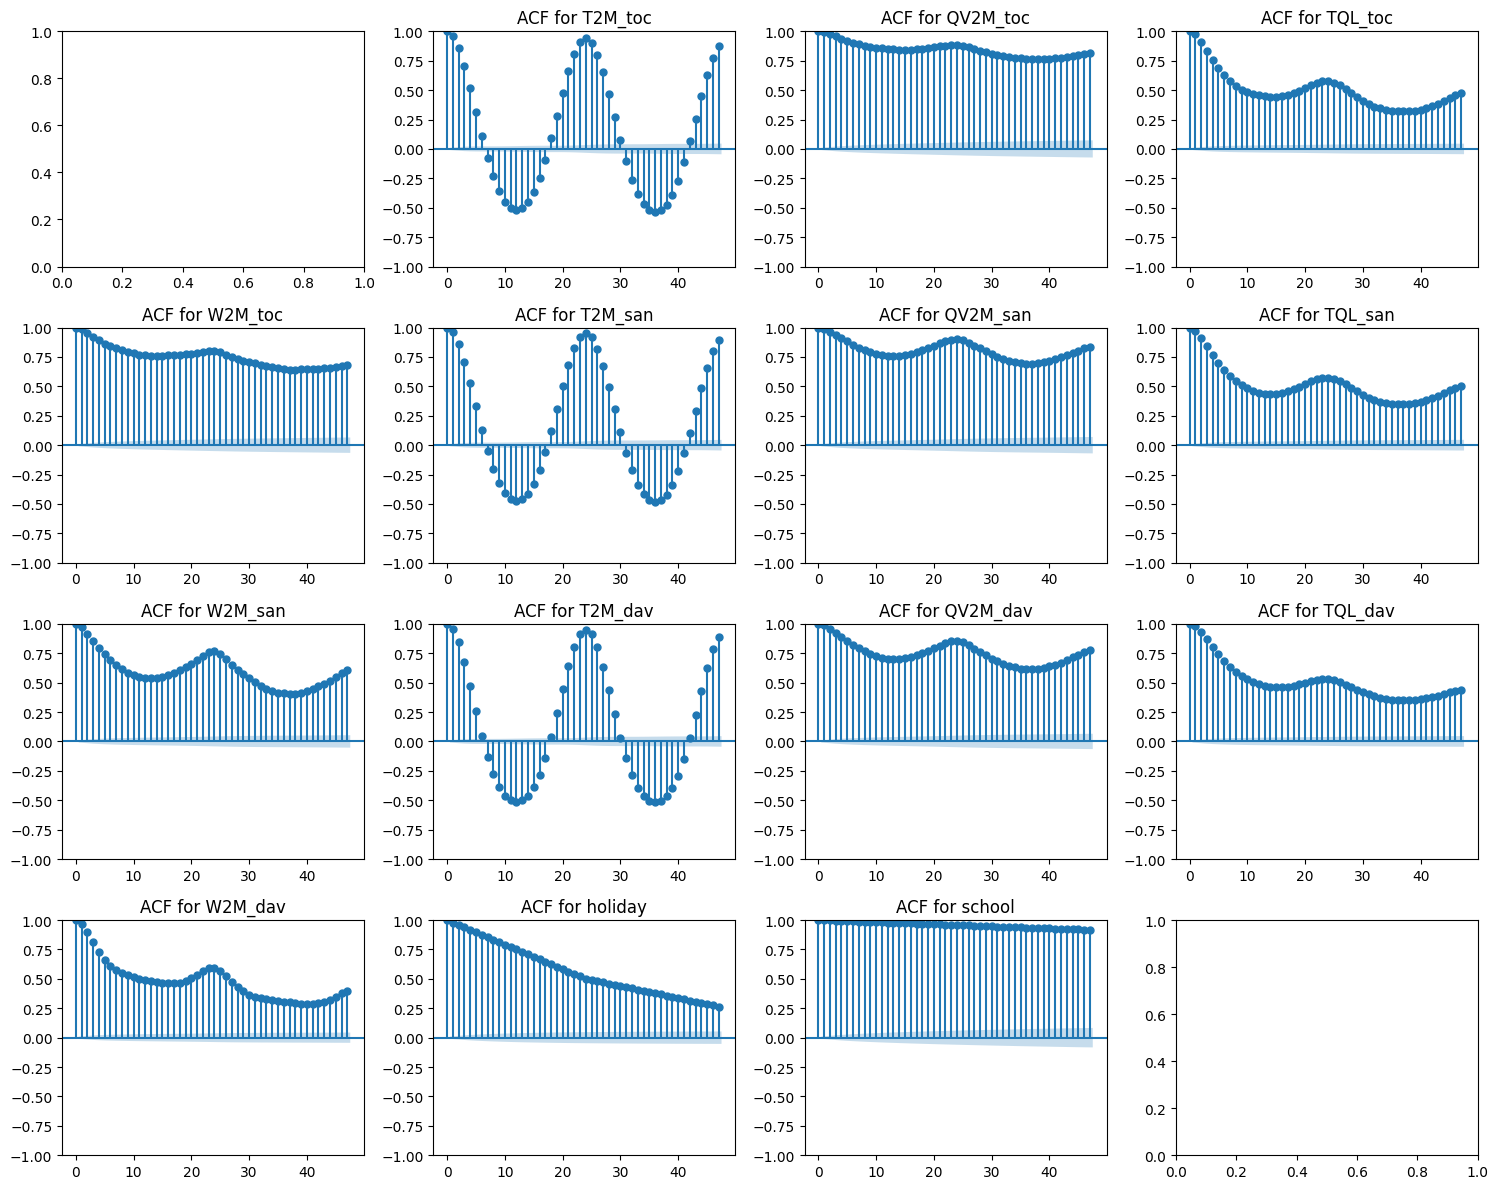

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Function to plot ACF for multiple features in a grid format
def plot_acf_grid(data, features, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
    axes = axes.flatten()
    for i, feature in enumerate(features):
        # Check if the feature exists in the DataFrame before plotting
        if feature in data.columns:
            plot_acf(data[feature].dropna(), ax=axes[i], title=f'ACF for {feature}')
        else:
            print(f"Warning: Feature '{feature}' not found in the DataFrame.")
    plt.tight_layout()
    plt.show()

# Define features
features = ['Nat_Demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san', 'QV2M_san',
            'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav', 'W2M_dav',
            'holiday', 'school', 'Hour', 'Day_of_Week', 'Month', 'Year']

# Plot ACF for features in a grid format
plot_acf_grid(continuous_dataset, features, rows=4, cols=4)

The ACF measures the correlation between the current value and its past values at different lags. Here's what the ACF plots indicate:

Text(0, 0.5, 'National Demand')

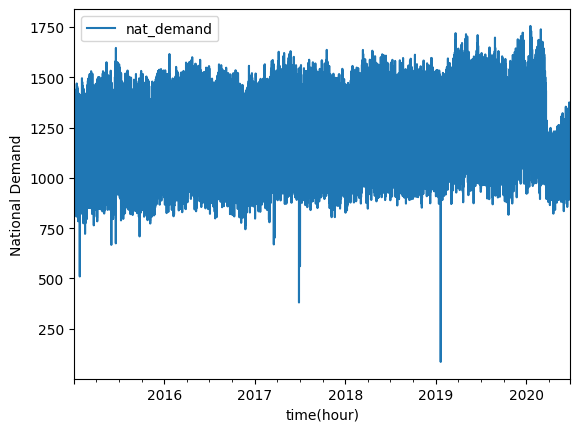

In [ ]:
continuous_dataset[['nat_demand']]['2015-01-03': '2020-06-27'].plot()

plt.xlabel('time(hour)')
plt.ylabel('National Demand')

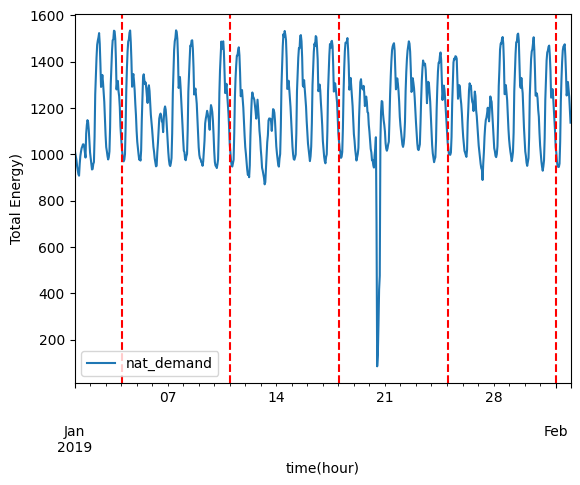

In [ ]:
continuous_dataset[['nat_demand' ]]['2019-01-01': '2019-02-01'].plot()

plt.xlabel('time(hour)')
plt.ylabel('Total Energy)')

# Adding vertical lines at the start of each week
min_date, max_date = continuous_dataset.index.min(), cont.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 4:
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

Text(0.5, 1.0, 'ACF Plot with Marked Peak at x=24 hours')

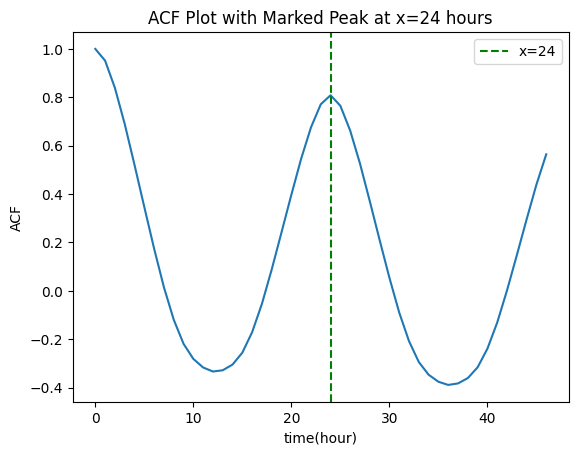

In [ ]:
from statsmodels.tsa.stattools import acf  # Import the acf function
plt.plot(acf(continuous_dataset['nat_demand']))
plt.xlabel('time(hour)')
plt.ylabel('ACF')
plt.axvline(x=24, color='green', linestyle='--', label='x=24')

plt.legend()
plt.title('ACF Plot with Marked Peak at x=24 hours')

Text(0, 0.5, 'Temperature by city')

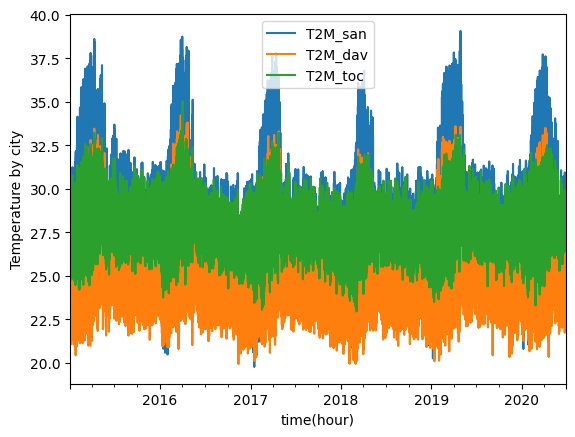

In [ ]:
continuous_dataset[['T2M_san', 'T2M_dav', 'T2M_toc']]['2015-01-03': '2020-06-27'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Temperature by city')

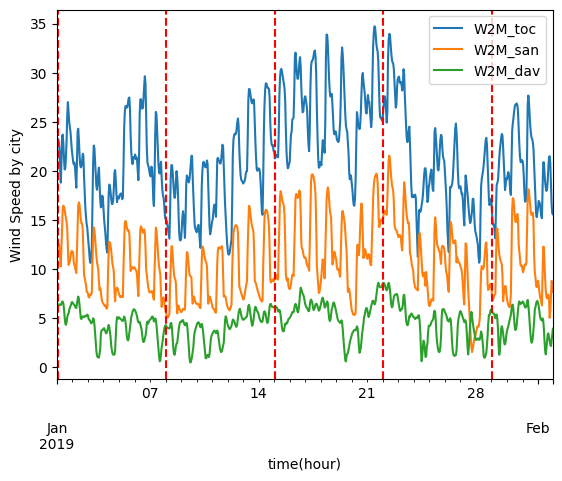

In [ ]:
continuous_dataset[[ 'W2M_toc', 'W2M_san', 'W2M_dav']]['2019-01-01': '2019-02-01'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Wind Speed by city')


# Adding vertical lines at the start of each week
min_date, max_date = continuous_dataset.index.min(), continuous_dataset.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.weekday() == 1:
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(days=1)

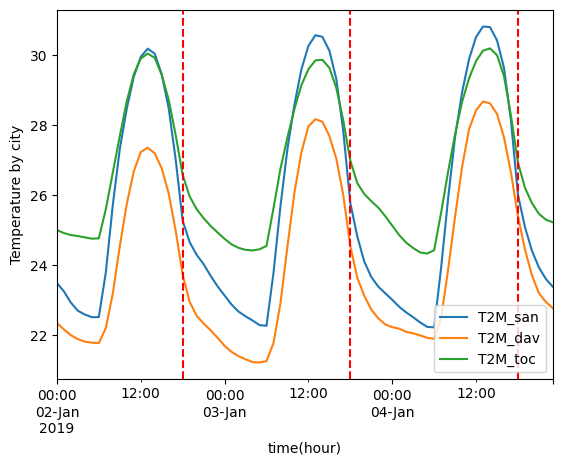

In [ ]:
continuous_dataset[['T2M_san', 'T2M_dav', 'T2M_toc']]['2019-01-02': '2019-01-04'].plot()
plt.xlabel('time(hour)')
plt.ylabel('Temperature by city')

# Adding vertical lines at the start of each week
min_date, max_date = continuous_dataset.index.min(), continuous_dataset.index.max()
current_date = min_date

while current_date <= max_date:
    if current_date.hour == 18:
        plt.axvline(x=current_date, color='red', linestyle='--')
    current_date += pd.Timedelta(hours=1)

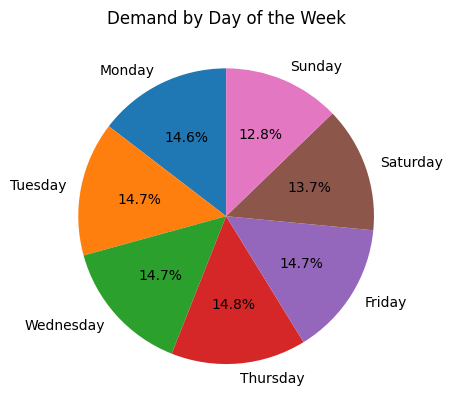

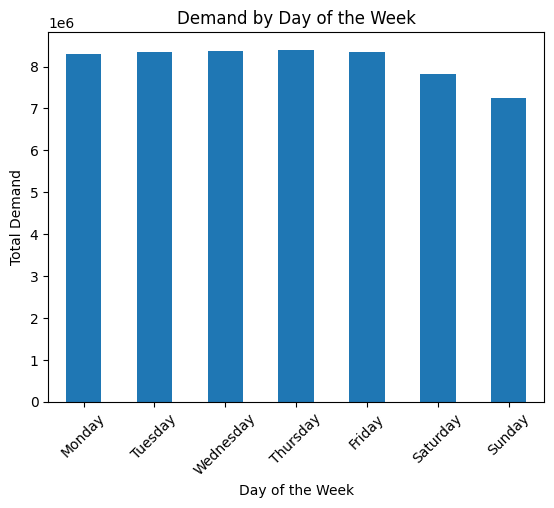

In [ ]:
# Extract 'Day_of_Week' from 'datetime'
continuous_dataset['Day_of_Week'] = continuous_dataset.index.day_name()

# Group by 'Day_of_Week' and sum 'Nat_Demand'
if 'nat_demand' in continuous_dataset.columns:
    demand_by_day = continuous_dataset.groupby('Day_of_Week')['nat_demand'].sum()

    # Ensure the days are in the correct order
    ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    demand_by_day = demand_by_day.reindex(ordered_days)

    # Plot pie chart
    demand_by_day.plot(kind='pie', autopct='%1.1f%%', startangle=90, title='Demand by Day of the Week')
    plt.ylabel('')
    plt.show()

    # Plot bar chart
    demand_by_day.plot(kind='bar', title='Demand by Day of the Week')
    plt.xlabel('Day of the Week')
    plt.ylabel('Total Demand')
    plt.xticks(rotation=45)

    # Add vertical lines at the start of each week (Tuesday)
    min_date, max_date = continuous_dataset.index.min(), continuous_dataset.index.max()
    current_date = min_date

    while current_date <= max_date:
        if current_date.weekday() == 1:  # Tuesday is represented by 1
            plt.axvline(x=current_date, color='red', linestyle='--')
        current_date += pd.Timedelta(days=1)

    plt.show()
else:
    raise KeyError("'Nat_Demand' column not found in the DataFrame.")

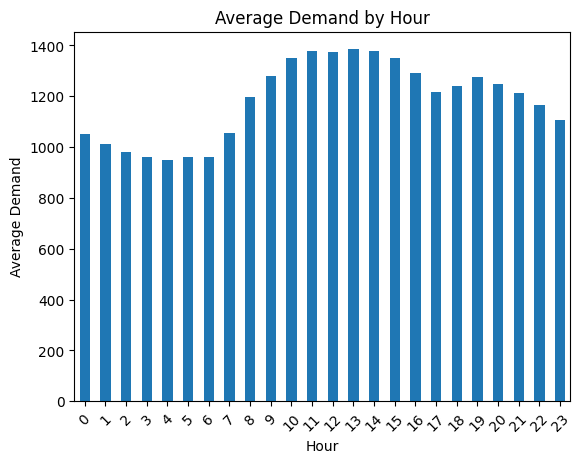

In [ ]:
# Extract 'hour' from 'datetime'
continuous_dataset['hour'] = continuous_dataset.index.hour

# Group by 'hour' and calculate the average demand
if 'nat_demand' in continuous_dataset.columns:
    average_demand_by_hour = continuous_dataset.groupby('hour')['nat_demand'].mean()

    # Plot bar chart
    average_demand_by_hour.plot(kind='bar', title='Average Demand by Hour')
    plt.xlabel('Hour')
    plt.ylabel('Average Demand')
    plt.xticks(rotation=45)
    plt.show()

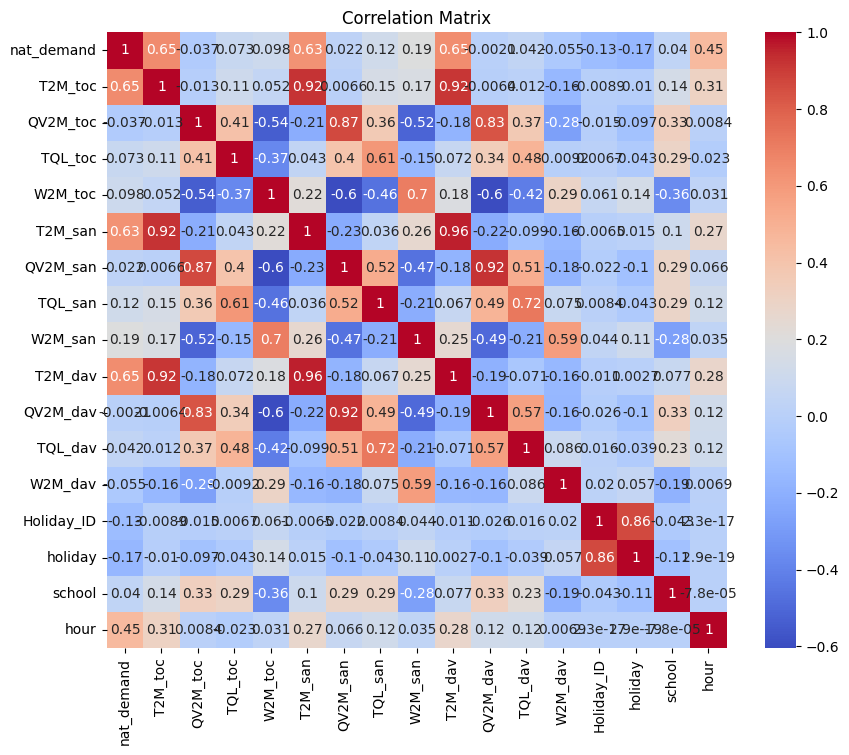

In [ ]:

# Select only numeric columns for correlation calculation
numeric_columns = continuous_dataset.select_dtypes(include='number').columns
correlation_matrix = continuous_dataset[numeric_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

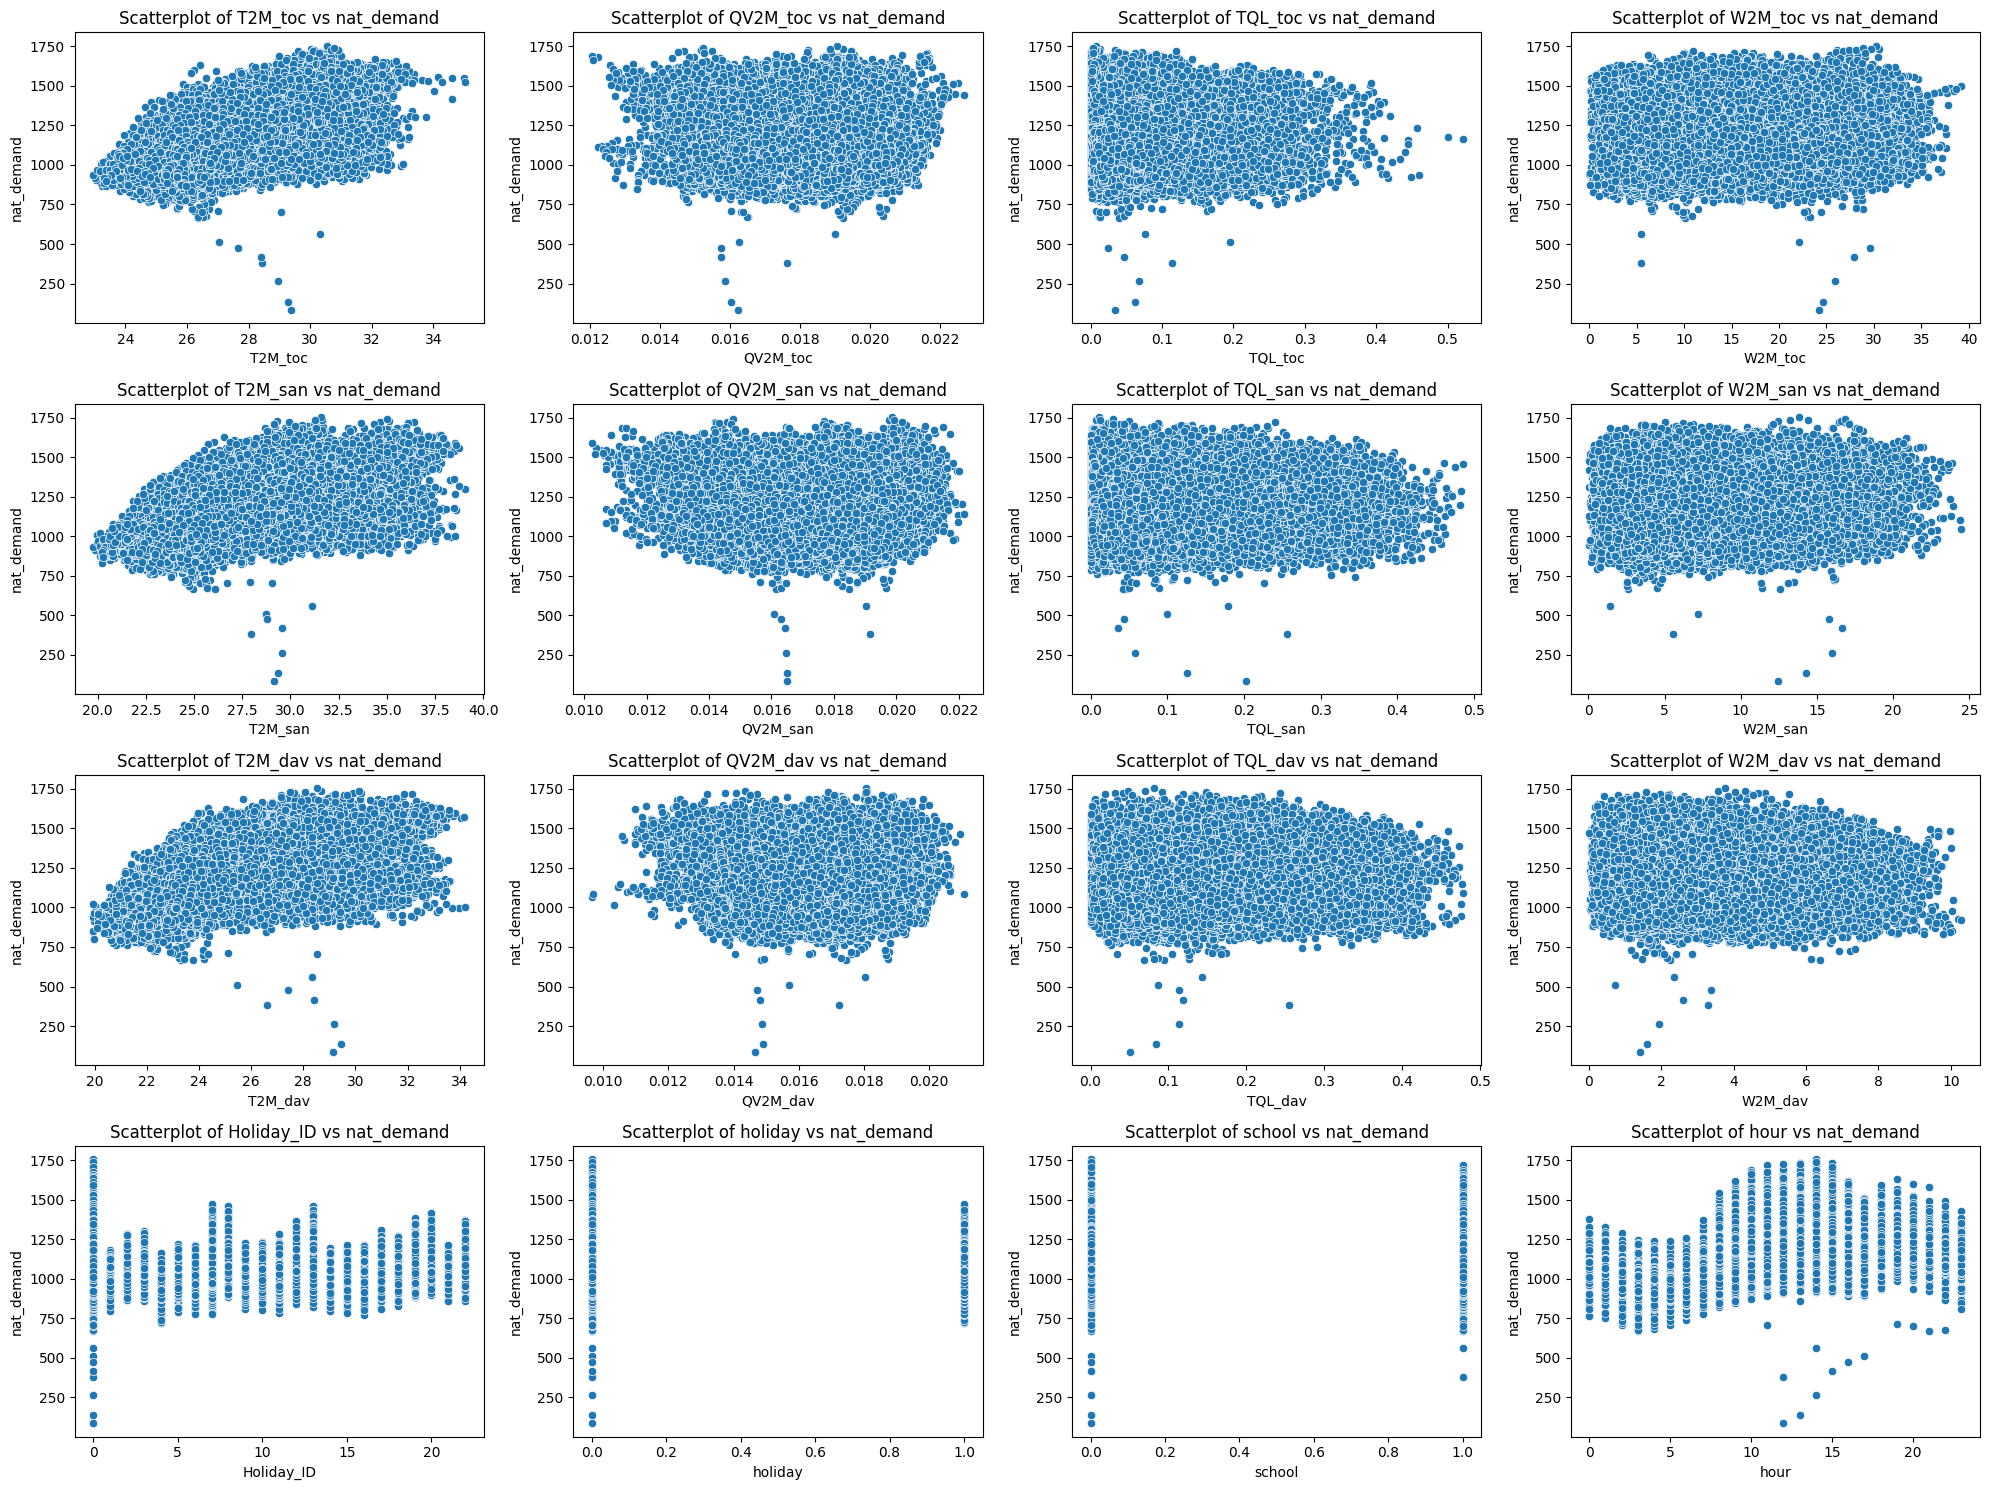

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Extract 'hour' and 'Day_of_Week' for other calculations (if needed)
continuous_dataset['hour'] = continuous_dataset.index.hour
continuous_dataset['Day_of_Week'] = continuous_dataset.index.day_name()

# Select numeric columns excluding the target column
variables = continuous_dataset.select_dtypes(include='number').columns.drop('nat_demand')

# Function to plot scatter plots for multiple variables in a grid format
def plot_scatter_grid(data, variables, target, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
    axes = axes.flatten()
    for i, var in enumerate(variables):
        sns.scatterplot(x=data[var], y=data[target], ax=axes[i])
        axes[i].set_title(f'Scatterplot of {var} vs {target}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel(target)
    plt.tight_layout()
    plt.show()

# Calculate the number of rows and columns needed
num_vars = len(variables)
rows = (num_vars // 4) + 1 if num_vars % 4 != 0 else num_vars // 4
cols = 4

# Plot scatter plots for variables in a grid format
plot_scatter_grid(continuous_dataset, variables, 'nat_demand', rows, cols)

<Figure size 1000x600 with 0 Axes>

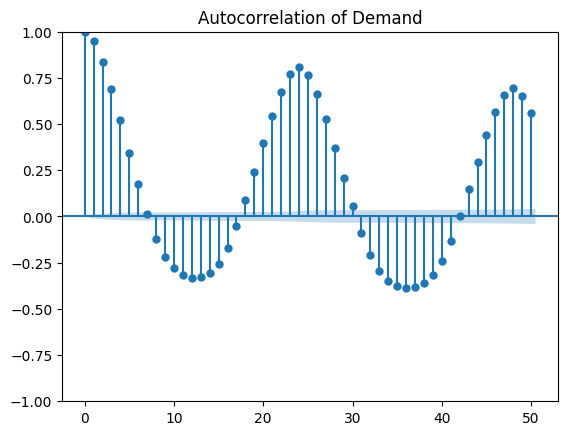

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation of demand
plt.figure(figsize=(10, 6))
plot_acf(continuous_dataset['nat_demand'], lags=50)
plt.title('Autocorrelation of Demand')
plt.show()

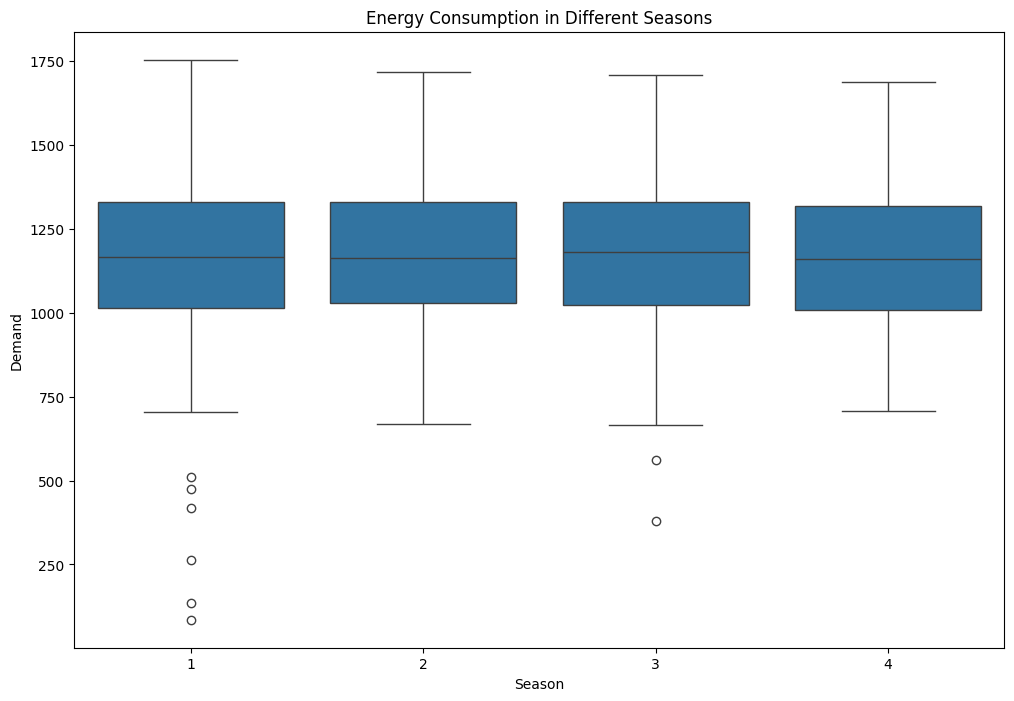

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'datetime' column is in datetime format
continuous_dataset.reset_index(inplace=True)  # Reset index to make 'datetime' a column
continuous_dataset['datetime'] = pd.to_datetime(continuous_dataset['datetime'])

# Add 'season' column
continuous_dataset['season'] = (continuous_dataset['datetime'].dt.month % 12 // 3) + 1

# Plot energy consumption in different seasons
plt.figure(figsize=(12, 8))
sns.boxplot(x='season', y='nat_demand', data=continuous_dataset)
plt.title('Energy Consumption in Different Seasons')
plt.xlabel('Season')
plt.ylabel('Demand')
plt.show()

## Modeling

ADF Statistic: -20.96175000729656
p-value: 0.0


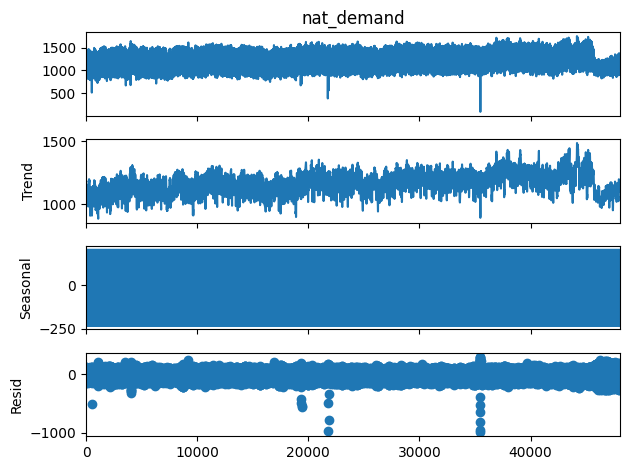

In [ ]:
# Augmented Dickey-Fuller Test
result = adfuller(continuous_dataset['nat_demand'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(continuous_dataset['nat_demand'], model='additive', period=24)
decomposition.plot()
plt.show()

In [ ]:
# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(continuous_dataset) * 0.8)
train, test = continuous_dataset[:train_size], continuous_dataset[train_size:]

In [ ]:
!pip install prophet

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfh4j3vkr/ce24z2i4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfh4j3vkr/evj_m4z0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59282', 'data', 'file=/tmp/tmpfh4j3vkr/ce24z2i4.json', 'init=/tmp/tm

38427/38427 ━━━━━━━━━━━━━━━━━━━━ 263s 7ms/step - loss: 0.0026
1201/1201 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


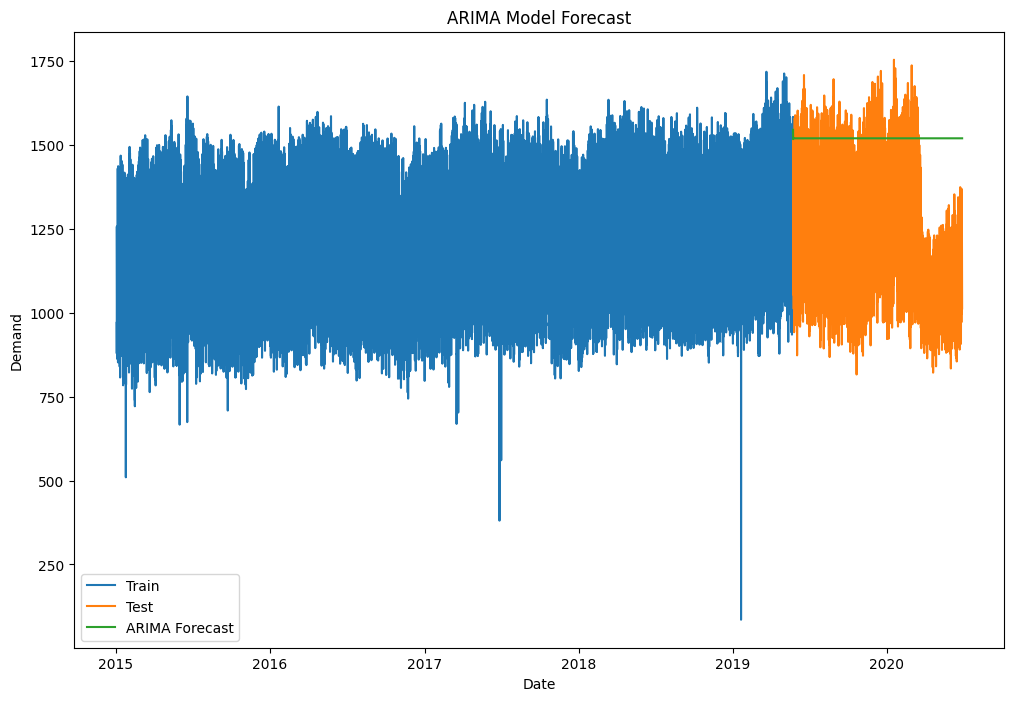

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


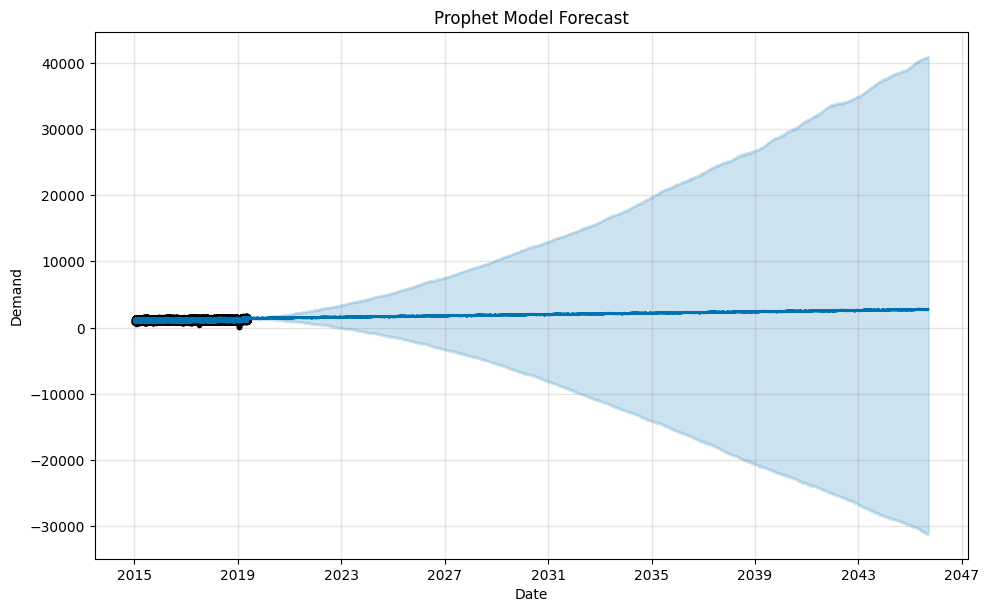

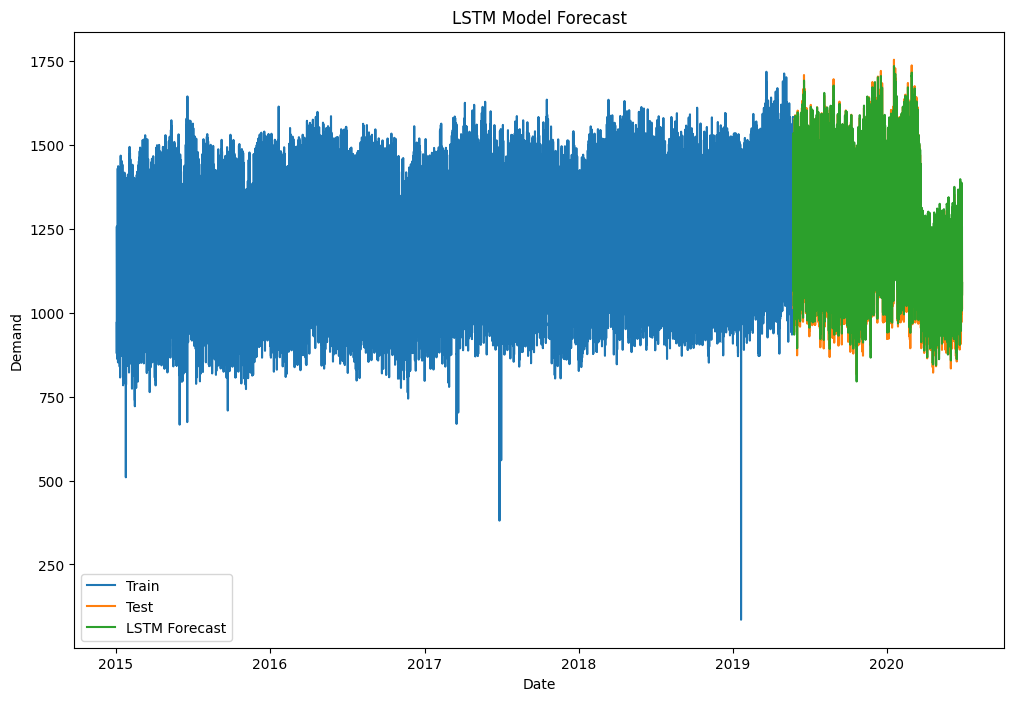

ARIMA RMSE: 360.375952364355, MAE: 318.1398013248337
Prophet RMSE: 1022.4963249243116, MAE: 907.846013624487
LSTM RMSE: 42.80046464686724, MAE: 35.73800977407925


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# Ensure 'datetime' column is in datetime format
continuous_dataset['datetime'] = pd.to_datetime(continuous_dataset['datetime'])
continuous_dataset.set_index('datetime', inplace=True)

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(continuous_dataset) * 0.8)
train, test = continuous_dataset[:train_size], continuous_dataset[train_size:]

# ARIMA Model
arima_model = ARIMA(train['nat_demand'], order=(5, 1, 0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

# Prophet Model
prophet_data = continuous_dataset.reset_index()[['datetime', 'nat_demand']].rename(columns={'datetime': 'ds', 'nat_demand': 'y'})
prophet_train = prophet_data[:train_size]
prophet_test = prophet_data[train_size:]

prophet_model = Prophet()
prophet_model.fit(prophet_train)
future = prophet_model.make_future_dataframe(periods=len(test))
forecast = prophet_model.predict(future)

# LSTM Model Preparation
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(data[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(continuous_dataset['nat_demand'].values.reshape(-1, 1))

train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, batch_size=1, epochs=1)

train_predict = lstm_model.predict(X_train)
test_predict = lstm_model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Adjust test index to match test_predict length
adjusted_test_index = test.index[time_step + 1:]

# Plotting Forecasts
plt.figure(figsize=(12, 8))
plt.plot(train.index, train['nat_demand'], label='Train')
plt.plot(test.index, test['nat_demand'], label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.show()

fig = prophet_model.plot(forecast)
plt.title('Prophet Model Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(train.index, continuous_dataset['nat_demand'].iloc[:train_size], label='Train')
plt.plot(test.index, continuous_dataset['nat_demand'].iloc[train_size:], label='Test')
plt.plot(adjusted_test_index, test_predict, label='LSTM Forecast')
plt.legend()
plt.title('LSTM Model Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.show()

# Model Evaluation
arima_rmse = np.sqrt(mean_squared_error(test['nat_demand'], arima_forecast))
arima_mae = mean_absolute_error(test['nat_demand'], arima_forecast)
print(f'ARIMA RMSE: {arima_rmse}, MAE: {arima_mae}')

prophet_forecast = forecast.iloc[train_size:]['yhat']
prophet_rmse = np.sqrt(mean_squared_error(prophet_test['y'], prophet_forecast))
prophet_mae = mean_absolute_error(prophet_test['y'], prophet_forecast)
print(f'Prophet RMSE: {prophet_rmse}, MAE: {prophet_mae}')

lstm_rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), test_predict))
lstm_mae = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1, 1)), test_predict)
print(f'LSTM RMSE: {lstm_rmse}, MAE: {lstm_mae}')

In [ ]:
# Exponential Smoothing Model
exp_model = ExponentialSmoothing(train['nat_demand'], seasonal='additive', seasonal_periods=24).fit()
exp_forecast = exp_model.forecast(len(test))

# Adjust test index to match test_predict length
adjusted_test_index = test.index[time_step + 1:]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


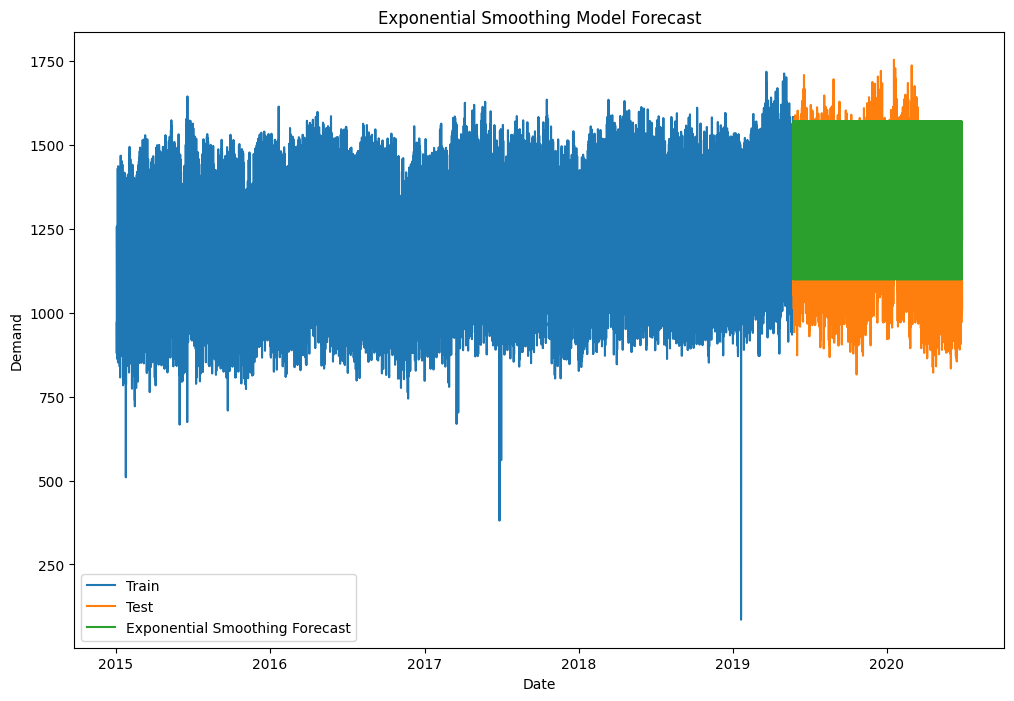

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(train.index, train['nat_demand'], label='Train')
plt.plot(test.index, test['nat_demand'], label='Test')
plt.plot(test.index, exp_forecast, label='Exponential Smoothing Forecast')
plt.legend()
plt.title('Exponential Smoothing Model Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.show()

(Blue Line): This line shows the actual national electricity demand for the training period.

(Orange Line): This line shows the actual national electricity demand for the test period. This data is used to evaluate the model's forecasting performance.
(Green Line): This line represents the predicted national electricity demand for the test period.